# Nengo + Nengo_dl + Tensorflow

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import gzip
import os
import pickle
from urllib.request import urlretrieve

import nengo
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/version.py:32: UserWarning: This version of `nengo_dl` has not been tested with your `nengo` version (3.0.0.dev0). The latest fully supported version is 2.8.0.
  ((nengo.version.version,) + latest_nengo_version))


## Example in Nengo-DL website
[NengoDL with Tnesorflow](https://www.nengo.ai/nengo-dl/v2.1.1/examples/from-tensorflow.html)

Nengo DL How to

In [2]:
with nengo.Network() as net:
    # node to provide an input value for the TensorNode
    a = nengo.Node([0.5, -0.1])

    # a TensorNode function to illustrate i/o
    def tensor_func(t, x):
        # print out the value of inputs t and x
        t = nengo_dl.utils.print_op(t, "t:")
        with tf.control_dependencies([t]):
            x = nengo_dl.utils.print_op(x, "x:")

        # output t + x
        return tf.add(t, x)

    # create the TensorNode
    b = nengo_dl.TensorNode(tensor_func, size_in=2)
    nengo.Connection(a, b, synapse=None)

    p = nengo.Probe(b)

with nengo_dl.Simulator(net) as sim:
    print("TensorNode input:")
    sim.run_steps(10, progress_bar=False)
    print("TensorNode output:")
    print(sim.data[p])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|#                        Constructing graph                          | 0:00:00WARNING:tensorflow:From /home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


/home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/nengo_dl/simulator.py:131: UserWarning: No GPU support detected. It is recommended that you install tensorflow-gpu (`pip install tensorflow-gpu`).
  "No GPU support detected. It is recommended that you "
Instructions for updating:
Colocations handled automatically by placer.


Construction finished in 0:00:00                                               
TensorNode input:
t: 0.001
x: [[ 0.5 -0.1]]
t: 0.002
x: [[ 0.5 -0.1]]
t: 0.003
x: [[ 0.5 -0.1]]
t: 0.004
x: [[ 0.5 -0.1]]
t: 0.0050000004
x: [[ 0.5 -0.1]]
t: 0.006
x: [[ 0.5 -0.1]]
t: 0.007
x: [[ 0.5 -0.1]]
t: 0.008
x: [[ 0.5 -0.1]]
t: 0.009000001
x: [[ 0.5 -0.1]]
t: 0.010000001
x: [[ 0.5 -0.1]]
TensorNode output:
[[ 0.501 -0.099]
 [ 0.502 -0.098]
 [ 0.503 -0.097]
 [ 0.504 -0.096]
 [ 0.505 -0.095]
 [ 0.506 -0.094]
 [ 0.507 -0.093]
 [ 0.508 -0.092]
 [ 0.509 -0.091]
 [ 0.51  -0.09 ]]


In [3]:
with nengo.Network() as net:
    class TensorFunc:
        def pre_build(self, shape_in, shape_out):
            # shape_in and shape_out are the input and output shape of
            # the TensorNode

            print("in pre_build, scope:",
                  tf.get_default_graph().get_name_scope())

        def __call__(self, t, x):
            # this is the main tensornode function, equivalent to the
            # tensor_func discussed above

            print("in build, scope:",
                  tf.get_default_graph().get_name_scope())
            return x

        def post_build(self, sess, rng):
            # post_build is called after the Simulator's underlying
            # tf.Session is initialized, and that Session is passed
            # in as `sess`. `rng` is the Simulator's random number
            # generator.

            print("in post_build, scope:",
                  tf.get_default_graph().get_name_scope())

    a = nengo_dl.TensorNode(TensorFunc(), size_in=1, size_out=1)

# build the network
with nengo_dl.Simulator(net, progress_bar=False) as sim:
    pass

in pre_build, scope: SimTensorNodeBuilder
in build, scope: while/iteration_0/SimTensorNodeBuilder
in post_build, scope: SimTensorNodeBuilder_1


MNIST Nengo DL

In [4]:
# download MNIST dataset
urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz",
            "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz") as f:
    (train_data, _), _, (test_data, _) = pickle.load(
        f, encoding="latin1")
np.random.shuffle(train_data)

n_epochs = 2

In [8]:
n_in = 784
n_hidden = 64
minibatch_size = 50

with tf.Graph().as_default() as auto_graph:
    # input
    tf_a = tf.placeholder(tf.float32, shape=(minibatch_size, n_in))

    # first layer
    tf_b = tf.layers.dense(
        tf_a, n_hidden, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.glorot_uniform())

    # second layer
    tf_c = tf.layers.dense(
        tf_b, n_in, activation=tf.nn.relu,
        kernel_initializer=tf.initializers.glorot_uniform())

Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use keras.layers.dense instead.


In [10]:
with nengo.Network() as auto_net:
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(
        n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    nengo_c = nengo.Ensemble(
        n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons,
        transform=nengo_dl.dists.Glorot())

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

Look into parameter shapes

In [16]:
n_in, n_hidden

(784, 64)

In [19]:
type(nengo_c), type(nengo_c.neurons),type(p_c)

(nengo.ensemble.Ensemble, nengo.ensemble.Neurons, nengo.probe.Probe)

Simulation

In [11]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               ##################################################################################################################################################################################################################################################################################################################| ETA: 0:00:00
|                   Training (0%)                  | ETA:  --:--:-- (loss: ---)WARNING:tensorflow:From /home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


|#################Training (99%)################# | ETA: 0:00:00 (loss: 0.0110)WARNING:tensorflow:From /home/kurihana/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Training finished in 0:00:21 (loss: 0.0138)                                    
Calculation finished in 0:00:01                                                
error: 0.0129718995


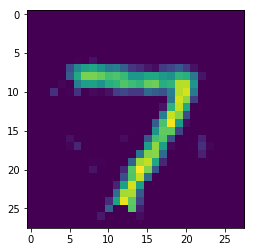

In [13]:
# define loss function (we could use the pre-defined
# `nengo_dl.obj.mse`, but we define it explicitly here
# for clarity)
def loss(outputs, targets):
    return tf.reduce_mean(tf.square(outputs - targets))

with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    # sim.train automatically adds the necessary elements to the
    # graph and runs the training loop
    # note: the probe acts as the placeholder to feed in target values
    sim.train({nengo_a: train_data, p_c: train_data},
              tf.train.RMSPropOptimizer(1e-3),
              objective={p_c: loss}, n_epochs=n_epochs)

    # evaluate performance on test set
    error = sim.loss({nengo_a: test_data, p_c: test_data},
                     objective={p_c: loss})
    print("error:", error)

    # display example output
    sim.step(data={nengo_a: test_data[:minibatch_size]})
    plt.figure()
    plt.imshow(sim.data[p_c][0].reshape((28, 28)))